## Confidentiality

This notebook is downloaded from Quantopian and is for demonstrational purposes only.

Please do not copy or distribute this notebook.


## Introduction

This notebook can't be run in Google Colab and should be run in Quantopian Research and Quantopian IDE.

In [ ]:
from quantopian.pipeline import Pipeline

def initialize(context):
    my_pipe = make_pipeline()

def make_pipeline():
    return Pipeline()


## Attaching a Pipe

In research, A make_pipeline was run to create an instance of a pipeline object and run_pipeline was used to run the pipeline over a specified date range. You cannot safely do this in an algorithm, so the simulation has to be allowed to run the pipeline for you. In order for the simulation to run the pipeline, you must attach the pipeline with attach_pipeline.

The attach_pipeline function requires two arguments: a reference to the Pipeline object, and a string name for the pipeline which can be decided arbitrarily. Let's import attach_pipeline and attach the empty pipeline in the skeleton example.

In [ ]:
import quantopian.algorithm as algo
from quantopian.pipeline import Pipeline

def initialize(context):
    my_pipe = make_pipeline()
    algo.attach_pipeline(my_pipe, 'my_pipeline')

def make_pipeline():
    return Pipeline()

Now that the pipeline is attached, it will be run once each day of the simulation. If an algorithm is backtested or live traded from Monday, June 6, 2016 to Friday, Jun 10, 2016, the pipeline will be run once on each day of the week (5 times total). Attaching the pipeline will produce a new output dataframe each day. The daily output is similar to the output of run_pipeline in research. However, the output dataframe in the algorithm will not include the date in the index, as the current simulation date is implied to be the date of the pipeline computations.

## Pipeline Output

The daily output of the pipeline can be retrieved using pipeline_output in before_trading_start. pipeline_output requires the name of the attached pipeline as an argument and returns the output dataframe for the current date in the simulation. Let's import pipeline_output and modify the skeleton example to store the pipeline output in context each day.

In [ ]:
import quantopian.algorithm as algo
from quantopian.pipeline import Pipeline

def initialize(context):
    my_pipe = make_pipeline()
    algo.attach_pipeline(my_pipe, 'my_pipeline')

def make_pipeline():
    return Pipeline()

def before_trading_start(context, data):
    # Storing the pipeline output DataFrame in context.
    context.output = algo.pipeline_output('my_pipeline')

The skeleton example now produces an empy dataframe with 8000+ rows and 0 columns each day. The output dataframe will look like this (note that the index is no longer a MultiIndex as it was in research):

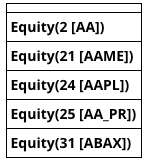

## Using the Pipeline From Research

To include the pipeline that was created in the previous algorithm, you can simply copy the make_pipeline function that was wrote in research to the algorithm as well as the required import statements. The following will run the pipeline and store the output dataframe with 150 rows and 2 columns (longs and shorts) in context each day.

In [ ]:
import quantopian.algorithm as algo
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS

def initialize(context):
    my_pipe = make_pipeline()
    algo.attach_pipeline(my_pipe, 'my_pipeline')

def make_pipeline():
    """
    Creating the pipeline.
    """

    # Base universe set to the QTradableStocksUS.
    base_universe = QTradableStocksUS()

    # 10-day close price average.
    mean_10 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=10,
        mask=base_universe
    )

    # 30-day close price average.
    mean_30 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=30,
        mask=base_universe
    )

    percent_difference = (mean_10 - mean_30) / mean_30

    # Filtering to select securities to short.
    shorts = percent_difference.top(75)

    # Filtering to select securities to long.
    longs = percent_difference.bottom(75)

    # Filtering for all securities that you want to trade.
    securities_to_trade = (shorts | longs)

    return Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts
        },
        screen=(securities_to_trade),
    )

def before_trading_start(context, data):
    # Storing the pipeline output DataFrame in context
    context.output = algo.pipeline_output('my_pipeline')

The output from this pipeline will look something like this every day:


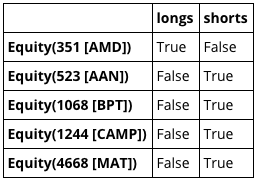

You can then define some functions to compute target weights and place orders for the long and short positions as specified by the pipeline output. Let's use some of the basics to implement weight calculations and ordering.

In [ ]:
def compute_target_weights(context, data):
    """
    Compute ordering weights.
    """

    # Initializing empty target weights dictionary.
    # This will map securities to their target weight.
    weights = {}

    # If there are securities in the longs and shorts lists,
    # computing even target weights for each security.
    if context.longs and context.shorts:
        long_weight = 0.5 / len(context.longs)
        short_weight = -0.5 / len(context.shorts)
    else:
        return weights

    # Exiting positions in the portfolio if they are not
    # in the longs or shorts lists.
    for security in context.portfolio.positions:
        if security not in context.longs and security not in context.shorts and data.can_trade(security):
            weights[security] = 0

    for security in context.longs:
        weights[security] = long_weight

    for security in context.shorts:
        weights[security] = short_weight

    return weights

def before_trading_start(context, data):
    """
    Getting pipeline results.
    """

    # Gets the pipeline output every day.
    pipe_results = algo.pipeline_output('my_pipeline')

    # Go long in securities for which the 'longs' value is True,
    # and checking if they can be traded.
    context.longs = []
    for sec in pipe_results[pipe_results['longs']].index.tolist():
        if data.can_trade(sec):
            context.longs.append(sec)

    # Go short in securities for which the 'shorts' value is True,
    # and checking if they can be traded.
    context.shorts = []
    for sec in pipe_results[pipe_results['shorts']].index.tolist():
        if data.can_trade(sec):
            context.shorts.append(sec)

def my_rebalance(context, data):
    """
    Rebalance weekly.
    """

    # Calculating target weights to rebalance
    target_weights = compute_target_weights(context, data)

    # If you have target weights, rebalancing the portfolio
    if target_weights:
        algo.order_optimal_portfolio(
            objective=opt.TargetWeights(target_weights),
            constraints=[],
        )

Finally, let's put everything together. And specify the algorithm to rebalance weekly.

In [ ]:
from quantopian.algorithm import order_optimal_portfolio
from quantopian.algorithm import attach_pipeline, pipeline_output
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS
import quantopian.optimize as opt

def initialize(context):
    # Scheduling the rebalance function to run at the start of
    # each week, when the market opens.
    schedule_function(
        my_rebalance,
        date_rules.week_start(),
        time_rules.market_open()
    )

    # Creating the pipeline and attaching it to the algorithm.
    my_pipe = make_pipeline()
    attach_pipeline(my_pipe, 'my_pipeline')

def make_pipeline():
    """
    Creating the pipeline.
    """

    # Base universe set to the QTradableStocksUS.
    base_universe = QTradableStocksUS()

    # 10-day close price average.
    mean_10 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=10,
        mask=base_universe
    )

    # 30-day close price average.
    mean_30 = SimpleMovingAverage(
        inputs=[USEquityPricing.close],
        window_length=30,
        mask=base_universe
    )

    percent_difference = (mean_10 - mean_30) / mean_30

    # Filtering to select securities to short.
    shorts = percent_difference.top(75)

    # Filtering to select securities to long.
    longs = percent_difference.bottom(75)

    # Filtering for all securities that you want to trade.
    securities_to_trade = (shorts | longs)

    return Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts
        },
        screen=(securities_to_trade),
    )

def compute_target_weights(context, data):
    """
    Computing ordering weights.
    """

    # Initializing empty target weights dictionary.
    # This will map securities to their target weight.
    weights = {}

    # If there are securities in the longs and shorts lists,
    # compute even target weights for each security.
    if context.longs and context.shorts:
        long_weight = 0.5 / len(context.longs)
        short_weight = -0.5 / len(context.shorts)
    else:
        return weights

    # Exit positions in the portfolio if they are not
    # in the longs or shorts lists.
    for security in context.portfolio.positions:
        if security not in context.longs and security not in context.shorts and data.can_trade(security):
            weights[security] = 0

    for security in context.longs:
        weights[security] = long_weight

    for security in context.shorts:
        weights[security] = short_weight

    return weights

def before_trading_start(context, data):
    """
    Get pipeline results.
    """

    # Gets the pipeline output every day.
    pipe_results = pipeline_output('my_pipeline')

    # Go long in securities for which the 'longs' value is True,
    # and checking if they can be traded.
    context.longs = []
    for sec in pipe_results[pipe_results['longs']].index.tolist():
        if data.can_trade(sec):
            context.longs.append(sec)

    # Go short in securities for which the 'shorts' value is True,
    # and checking if they can be traded.
    context.shorts = []
    for sec in pipe_results[pipe_results['shorts']].index.tolist():
        if data.can_trade(sec):
            context.shorts.append(sec)

def my_rebalance(context, data):
    """
    Rebalance weekly.
    """

    # Calculating target weights to rebalance
    target_weights = compute_target_weights(context, data)

    # If you have target weights, rebalancing the portfolio
    if target_weights:
        order_optimal_portfolio(
            objective=opt.TargetWeights(target_weights),
            constraints=[],
        )